In [1]:
from skeletonization.skeletonizer import Skeletonizer
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skeletonization.bonetypes import common
from scipy import ndimage
from scipy.optimize import linear_sum_assignment
import networkx as nx
from graphn import optimal_sequence_bijection_rij
from collections import defaultdict

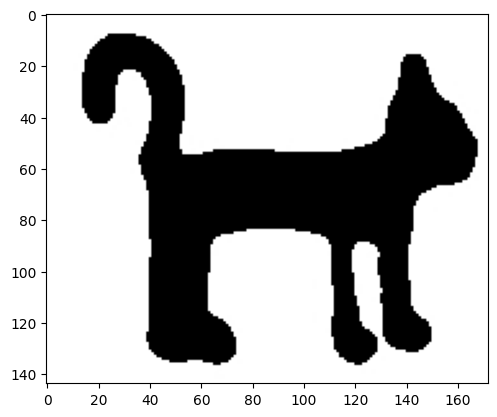

In [2]:
img = cv2.imread('cat_1_mask_classical.jpg')
img = ~img
plt.imshow(img)
plt.show()

In [3]:
skeletonizer = Skeletonizer(img)
skeleton = skeletonizer.skeletonize(30,3,10)

In [4]:
segmented = cv2.imread('cat_1_segmented_data.jpg',cv2.IMREAD_GRAYSCALE)
segmented = cv2.resize(segmented,(img.shape[1],img.shape[0]))
skeleton.identify(segmented)

In [5]:
joint_type_to_color = {
    common.JointType.LIMB : 'b',
    common.JointType.BODY : 'g',
    common.JointType.HEAD : 'r',
    common.JointType.WING : 'm',
    common.JointType.MIXED : 'c',
    common.JointType.NONE : 'y'
}

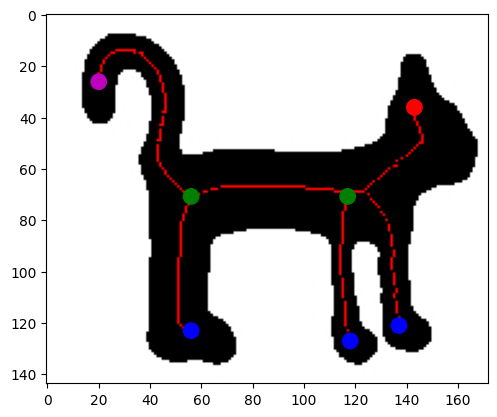

In [6]:
visiualize = np.copy(img)

for bone in skeleton.get_bones():
    for point in bone[1]:
        visiualize[int(point[1])][int(point[0])] = [255,0,0]

fig, ax = plt.subplots()
ax.imshow(visiualize)
for joint in skeleton.joints:
    circle = patches.Circle((joint.position[0], joint.position[1]),3,color=joint_type_to_color[joint.type])
    ax.add_patch(circle)
plt.show()

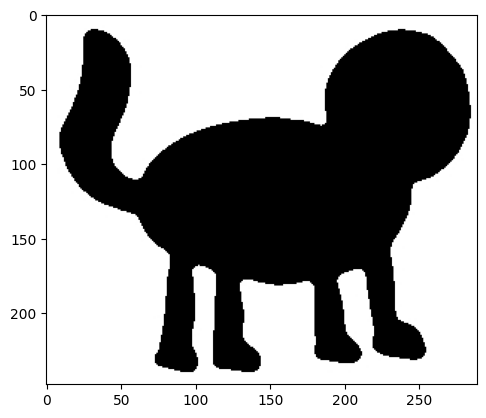

In [7]:
prototype_img = cv2.imread("cat_proto_mask.jpg",cv2.IMREAD_COLOR)
prototype_img = ~prototype_img
plt.imshow(prototype_img)
plt.show()

In [8]:
proto_skeletonizer = Skeletonizer(prototype_img)
proto_skeleton = proto_skeletonizer.skeletonize(30,3,10)
proto_segmented = cv2.imread('cat_proto_segment.jpg',cv2.IMREAD_GRAYSCALE)
proto_segmented = cv2.resize(proto_segmented,(prototype_img.shape[1],prototype_img.shape[0]))
proto_skeleton.identify(proto_segmented)

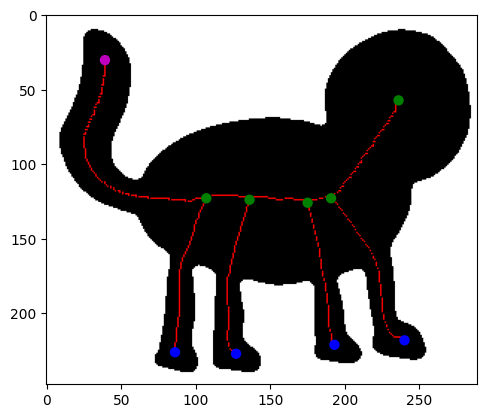

In [9]:
visiualize_proto = np.copy(prototype_img)

for bone in proto_skeleton.get_bones():
    for point in bone[1]:
        visiualize_proto[int(point[1])][int(point[0])] = [255,0,0]

fig, ax = plt.subplots()
ax.imshow(visiualize_proto)
for joint in proto_skeleton.joints:
    circle = patches.Circle((joint.position[0], joint.position[1]),3,color=joint_type_to_color[joint.type])
    ax.add_patch(circle)
plt.show()

In [10]:
subject_endpoints = skeleton.find_endpoints()
prototype_endpoints = proto_skeleton.find_endpoints()

print(f"Subject Endpoints: {subject_endpoints} | Prototype Endpoints: {prototype_endpoints}")

ordered_subject_endpoints = skeleton.order_points(subject_endpoints)
ordered_prototype_endpoints = proto_skeleton.order_points(prototype_endpoints)

print(f"Ordered Subject Endpoints: {ordered_subject_endpoints} | Ordered Prototype Endpoints: {ordered_prototype_endpoints}")

Subject Endpoints: [2, 3, 4, 5, 6] | Prototype Endpoints: [4, 5, 6, 7, 8, 9]
Ordered Subject Endpoints: [6, 2, 3, 4, 5] | Ordered Prototype Endpoints: [9, 4, 5, 6, 7, 8]


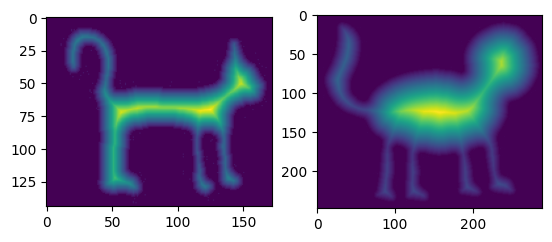

In [11]:
subject_distance_transfrom = ndimage.distance_transform_edt(~img)[:,:,0]
subject_normalizer_dt = 1 / (sum(sum(subject_distance_transfrom))/2)
normalized_subject_distance_transform = subject_distance_transfrom * subject_normalizer_dt

prototype_distance_transfrom = ndimage.distance_transform_edt(~prototype_img)[:,:,0]
prototype_normalizer_dt = 1 / (sum(sum(prototype_distance_transfrom))/2)
normalized_prototype_distance_transform = prototype_distance_transfrom * prototype_normalizer_dt

fig, axs = plt.subplots(ncols=2)

axs[0].imshow(normalized_subject_distance_transform*1000, cmap="viridis")
axs[1].imshow(normalized_prototype_distance_transform*1000, cmap="viridis")
plt.show()

## Get graph representation of skeletons

In [12]:
class SkeletonPath:
    def __init__(self, from_id, to_id, length, radii):
        self.from_id = from_id
        self.to_id = to_id
        self.length = length
        self.radii = radii

    def __str__(self):
        return "From: {0}\n To: {1}\n Length: {2}\n Radii: {3}".format(self.from_id, self.to_id, self.length, self.radii)

In [13]:
def path_distance(left: SkeletonPath, right: SkeletonPath, alpha: float):
    assert(len(left.radii) == len(right.radii))
    weighted_length = alpha * ((left.length - right.length) ** 2 / (left.length + right.length))
    distance = 0
    for i in range(len(left.radii)):
        left_radius = left.radii[i]
        right_radius = right.radii[i]
        radii_component = (left_radius - right_radius) ** 2 / (left_radius + right_radius)
        distance += radii_component
    distance += weighted_length
    return distance

In [14]:
def calculate_all_paths(skeleton, image):
    NUM_OF_SAMPLES = 10

    graph = skeleton.to_network_x()
    graph.remove_edges_from(nx.selfloop_edges(graph))
    ordered_endpoints = skeleton.order_points(skeleton.find_endpoints())
    distance_transform = ndimage.distance_transform_edt(~image)[:,:,0]
    normalizer_dt = 1 / (sum(sum(distance_transform))/2)

    paths = []
    for u in ordered_endpoints:
        for v in ordered_endpoints:
            if u == v:
                continue
            shortest_path = nx.shortest_path(graph, u, v)
            sampled_path = []
            for i in range(0,len(shortest_path)-1):
                [sampled_path.append(point) for point in skeleton.get_skeleton_path(shortest_path[i], shortest_path[i+1])]
            length = len(sampled_path)
            sample_ids = np.linspace(0, length-1, NUM_OF_SAMPLES, dtype=int)
            sampled_radii = []
            for i in sample_ids:
                x = int(sampled_path[i][0])
                y = int(sampled_path[i][1])
                sampled_radii.append(distance_transform[y][x] * normalizer_dt)
            paths.append(SkeletonPath(u,v,length,sampled_radii))
    return paths


In [15]:
subject_paths = defaultdict(list)
for p in calculate_all_paths(skeleton,img):
    subject_paths[p.from_id].append(p)
    
prototype_paths = defaultdict(list)
for p in calculate_all_paths(proto_skeleton, prototype_img):
    prototype_paths[p.from_id].append(p)

num_subject_end_nodes = len(subject_paths)
num_prototype_end_nodes = len(prototype_paths)

num_dummy_nodes = max(0, num_subject_end_nodes - num_prototype_end_nodes)

dummy_nodes = [None] * num_dummy_nodes

alpha = 0.1

matrix = np.zeros((num_subject_end_nodes + 1, num_prototype_end_nodes + num_dummy_nodes + 1))
i = 0
for paths in subject_paths.values():
    j = 0
    for paths_prime in prototype_paths.values():
        pd_i_j = np.zeros((len(paths), len(paths_prime)))
        for k in range(len(paths)):
            for l in range(len(paths_prime)):
                distance = path_distance(paths[k], paths_prime[l], alpha)
                pd_i_j[k, l] = distance
        _, length = optimal_sequence_bijection_rij(pd_i_j)
        matrix[i,j] = length
        j += 1
    for d in range(num_dummy_nodes):
        matrix[i, num_prototype_end_nodes + d] = 2.0 * np.mean(matrix[:num_subject_end_nodes, :num_prototype_end_nodes])
    i+=1

mean_value = np.mean(matrix[:-1, :-1])
matrix[len(subject_paths), :-1] = 2.0 * mean_value
matrix[:-1, len(prototype_paths)] = 2.0 * mean_value
matrix[len(subject_paths), len(prototype_paths)] = 2.0 * mean_value 
col_ind, row_ind = linear_sum_assignment(matrix)

matching = list(zip(row_ind, col_ind))

for a, b in matching:
    if a >= len(subject_paths) and b >= len(prototype_paths):
        continue
    if a >= len(subject_paths):
        print(f"Prototype joint at {proto_skeleton.get_joint(proto_skeleton.order_points(proto_skeleton.find_endpoints())[b]).position} is unmatched.")
    elif b >= len(prototype_paths):
        print(f"Subject joint {skeleton.get_joint(skeleton.order_points(skeleton.find_endpoints())[a])} is unmatched.")
    else:
        print(f"Subject joint at {skeleton.get_joint(skeleton.order_points(skeleton.find_endpoints())[a]).position} is matched with prototype joint at {proto_skeleton.get_joint(proto_skeleton.order_points(proto_skeleton.find_endpoints())[b]).position}.")


Prototype joint at [np.float64(39.0), np.float64(30.0)] is unmatched.
Subject joint at [np.float64(143.0), np.float64(36.0)] is matched with prototype joint at [np.float64(236.0), np.float64(57.0)].
Subject joint at [np.float64(118.0), np.float64(127.0)] is matched with prototype joint at [np.float64(240.0), np.float64(218.0)].
Subject joint at [np.float64(56.0), np.float64(123.0)] is matched with prototype joint at [np.float64(193.0), np.float64(221.0)].
Subject joint at [np.float64(137.0), np.float64(121.0)] is matched with prototype joint at [np.float64(127.0), np.float64(227.0)].
Subject joint at [np.float64(20.0), np.float64(26.0)] is matched with prototype joint at [np.float64(86.0), np.float64(226.0)].
